# Классификация

Сохраните ваше решение в формате Name_Surname.ipynb, например Ivan_Ivanov.ipynb

Credits: [Евгений Соколов](https://github.com/esokolov)

### О задании

В этом задании вы:
- настроите метод опорных векторов
- познакомитесь с калибровочными кривыми и сравните вероятности, выдаваемые логистической регрессией и методом опорных векторов
- изучите методы работы с категориальными переменными

In [1]:
%pylab inline
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder

import numpy as np
from sklearn.model_selection import KFold

import tqdm

Populating the interactive namespace from numpy and matplotlib


## Часть 1. Метод опорных векторов и калибровка вероятностней

Сгенерируем синтетические данные.

In [2]:
X, y = make_classification(n_samples=100000, n_features=20,
                                    n_informative=10, n_redundant=10,
                                    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=42)

__Задание 1.__ Обучение и применение метода опорных векторов.

Обучите метод опорных векторов. На занятиях мы проходили обычный вариант, что соответствует линейному ядру (LinearSVC/LinearSVR в scikit-learn).

In [3]:
def get_proba(x):
    return 1. / (1. + np.exp(-1.*x))

In [4]:
clf = LinearSVC(random_state=42, max_iter=4000)
clf.fit(X_train, y_train)

/usr/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=4000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)

На тестовой части:
* постройте ROC и PR кривые.

    * [Отличия ROC от PR кривых.](http://www.chioka.in/differences-between-roc-auc-and-pr-auc/)

* посчитайте ROC-AUC, PR-AUC. 

In [5]:
y_scores = get_proba(clf.decision_function(X_test))

In [6]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_scores, pos_label=1)

precision, recall, thresholds = metrics.precision_recall_curve(y_test,
                                                               y_scores,
                                                               pos_label=1)

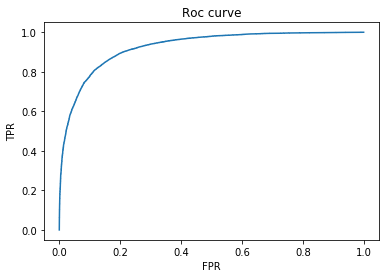

In [7]:
plt.title("Roc curve")
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

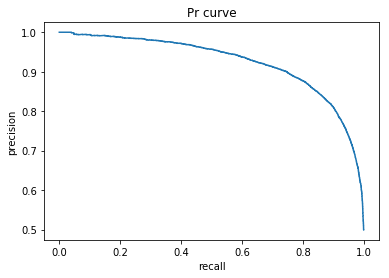

In [8]:
plt.title("Pr curve")
plt.plot(recall, precision)
plt.xlabel("recall")
plt.ylabel("precision")
plt.show()

In [9]:
roc_auc = metrics.roc_auc_score(y_test, y_scores)
pr_auc = metrics.auc(recall, precision)

In [10]:
print(f'ROC AUC {roc_auc}')
print(f'PR AUC {pr_auc}')

ROC AUC 0.9258677642357847
PR AUC 0.9247534742546762


В названии метода присутствуют некоторые "опорные векторы". Сгенерируйте синтетический датасет с помощью make_classification с 2 признаками, обучите на нём метод опорных векторов. Визуализируйте разделяющую прямую, все объекты и выделите опорные вектора (атрибут support\_vectors\_). В этот раз вместо LinearSVC воспользуйтесь SVC с линейным ядром (kernel='linear'), так как только в нём есть информация об опорных векторах.

In [11]:
X, y = make_classification(n_samples=100, n_features=2,
                           n_redundant=0, n_informative=2,
                           n_classes=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=42)

In [12]:
clf = SVC(kernel='linear', random_state=42)
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=42,
    shrinking=True, tol=0.001, verbose=False)

In [13]:
w = clf.coef_[0]
b = clf.intercept_[0]

xx = np.linspace(-2, 2, 30)
yy = (- b - w[0]*xx)/w[1]

YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

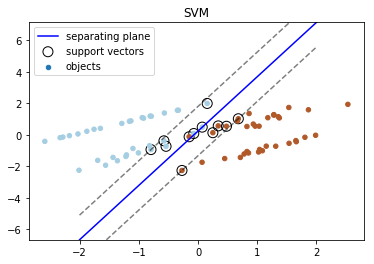

In [14]:
ax = plt.gca()

ax.scatter(clf.support_vectors_[:, 0],
           clf.support_vectors_[:, 1],
           s=100, linewidth=1, 
           facecolors='none', 
           edgecolors='k',
           label='support vectors')

plt.scatter(X_train[:, 0], X_train[:, 1],
            c=y_train, s=20,
            cmap=plt.cm.Paired,
            label='objects')

plt.plot(xx, yy,
        color='b',
        label='separating plane')

ax.contour(XX, YY, Z,
           colors='k', levels=[-1, 1],
           alpha=0.5,
           linestyles=['--', '--'])

plt.legend()
plt.title("SVM")
plt.show()

__Задание 2.__ Калибровка вероятностей.

Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых. 

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [15]:
X, y = make_classification(n_samples=5000, n_features=2,
                           n_redundant=0, n_informative=2,
                           n_classes=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=42)

In [16]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 20
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        tmp = y_test[(preds >= l) & (preds < r)]
        bin_real_ratios.append(np.mean(tmp))

    plt.plot(bin_middle_points, bin_real_ratios)
    plt.plot(bin_middle_points, bin_middle_points)

Постройте калибровочные кривые для логистической регрессии и метода опорных векторов. Изучите распределение ответов классификаторов (постройте гистограммы с помощью plt.hist). Чем они различаются? Чем вы можете объяснить это?

(Заметим, что метод опорных векторов не имеет метода predict_proba, но имеет метод decision_function)

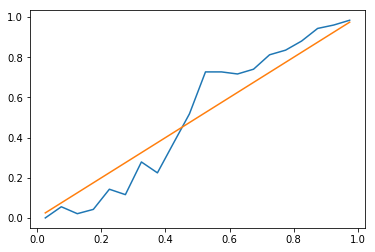

In [17]:
clf = SVC(kernel='linear', random_state=42)
clf.fit(X_train, y_train)

probas_svm = get_proba(clf.decision_function(X_test))
plot_calibration_curve(y_test, probas_svm)

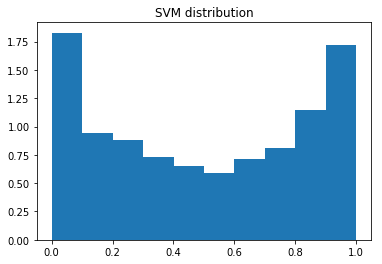

In [18]:
plt.hist(probas_svm, density=True)
plt.title('SVM distribution')
plt.show()

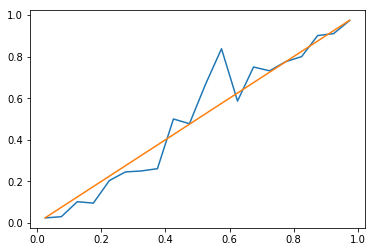

In [19]:
clf = LogisticRegression(random_state=42, solver='lbfgs', multi_class='ovr')
clf.fit(X_train, y_train)

probas_log = clf.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, probas_log)

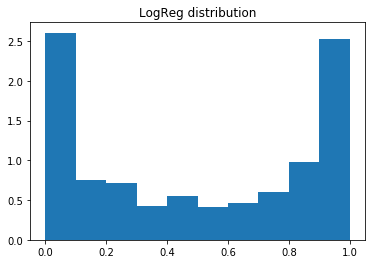

In [20]:
plt.hist(probas_log, density=True)
plt.title('LogReg distribution')
plt.show()

Калибровочная кривая для лог регрессии ближе к идеальной, чем у SVM, то же самое видно из гистограммы. Это происходит, потому что лог регрессия минимизирует такую функцию потерь, что можно оценивать вероятности классов, а в SVM используется максимум отступа (поэтому в центре гистограммы значения больше).

Воспользуйтесь CalibratedClassifierCV из sklearn для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

In [21]:
from sklearn.calibration import CalibratedClassifierCV

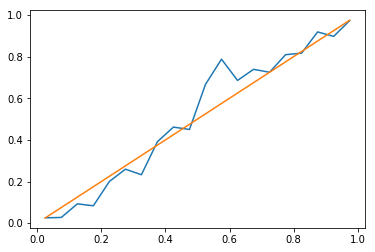

In [22]:
clf = CalibratedClassifierCV(SVC(kernel='linear', random_state=42), cv=5)
clf.fit(X_train, y_train)

probas = clf.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, probas)

Улучшилась.

## Часть 2. Работа с категориальными переменными

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Подготовка данных.__

Загрузим данные. Задача состоит в определении водителей, которые в ближайший год воспользуются своей автомобильной страховкой (бинарная классификация). При этом под нужды задания мы немного модифицируем датасет.

In [23]:
data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)

Пересемплируем выборку так, чтобы положительных и отрицательных объектов в выборке было одинаковое число. Разделим на обучающую и тестовую выборки.


In [24]:
# some resampling
np.random.seed(910)
mask_plus = np.random.choice(np.where(target == 1)[0], 100000, replace=True)
mask_zero = np.random.choice(np.where(target == 0)[0], 100000, replace=True)

data = pd.concat((data.iloc[mask_plus], data.iloc[mask_zero]))
target = np.hstack((target[mask_plus], target[mask_zero]))

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5)

__Задание 0.__ Посчитайте качество (в этом задании будем работать с ROC-AUC) на исходных признаках при применении логистической регрессии.

In [25]:
%%time
clf = LogisticRegression(random_state=42, solver='lbfgs', multi_class='ovr')
clf.fit(X_train, y_train)

probas = clf.predict_proba(X_test)[:, 1]
roc_auc = metrics.roc_auc_score(y_test, probas)
print(roc_auc)

0.6278489606709488
CPU times: user 14.9 s, sys: 6.79 s, total: 21.7 s
Wall time: 2.83 s


/usr/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


__Задание 1.__ Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было до кодирования). Измерьте время, потребовавшееся на обучение модели.

In [26]:
# остались с категориями
data._get_numeric_data().columns

Index(['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin',
       'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11',
       'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01',
       'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06',
       'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11',
       'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin',
       'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin',
       'ps_calc_20_bin'],
      dtype='obj

In [27]:
cat_columns = data.filter(regex='.*cat').columns
num_columns = list(set(data.columns) - set(cat_columns))

In [28]:
X_train_num = X_train[num_columns]
X_train_cat = X_train[cat_columns]

X_test_num = X_test[num_columns]
X_test_cat = X_test[cat_columns]

In [29]:
enc = OneHotEncoder(handle_unknown='ignore')
X_train_hot = enc.fit_transform(X_train_cat).todense()
X_test_hot = enc.transform(X_test_cat).todense()

In [30]:
X_train_hot = np.concatenate([X_train_hot, X_train_num], axis=1)
X_test_hot = np.concatenate([X_test_hot, X_test_num], axis=1)

In [31]:
%%time
clf = LogisticRegression(random_state=42, solver='lbfgs', multi_class='ovr')
clf.fit(X_train_hot, y_train)

probas = clf.predict_proba(X_test_hot)[:, 1]
roc_auc = metrics.roc_auc_score(y_test, probas)
print(roc_auc)

0.6394010719788653
CPU times: user 33.8 s, sys: 9.16 s, total: 42.9 s
Wall time: 5.46 s


/usr/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Как можно было заменить, one-hot-кодирование может сильно увеличивать количество признаков в датасете, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирование категориальных признаков — счётчики. Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{n=1}^{N} [f_j(x) = f_j(x_n)][y_n = +1]}{\sum_{n=1}^{N} [f_j(x) = f_j(x_n)]}
$$

[условие] обозначает индикатор условия: если условие выполнено, то 1, иначе 0.
$f_j(x)$ - $j$-й признак объекта $x$.

__Задание 2.__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущим экспериментов. Заметили ли вы что-то интересное?

In [32]:
import multiprocessing

In [33]:
def transform_one(X, y, C, x):
    filter_x = np.equal(X, x)
    filter_y = np.equal(y, 1)
    global_mean = np.mean(y)
    numerators = np.sum(np.logical_and(filter_x.T, filter_y).T, axis=0) + C * global_mean
    denumerators = np.sum(filter_x, axis=0) + C
    res = numerators / denumerators
    res[denumerators == 0] = 0
    return list(res)


class CounterEncoder:
    def __init__(self, C=0):
        self.X = None
        self.y = None
        self.C = C
        
    
    def fit(self, X, y):
        self.X = np.array(X)
        self.y = np.array(y)
    
    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)
        
    
    def transform(self, X):
        X = np.array(X)
        res = []
        with multiprocessing.Pool(8) as pool:
            args = []
            for i in tqdm.tqdm_notebook(range(len(X))):
                args.append((self.X, self.y, self.C, X[i]))
            res = pool.starmap(transform_one, args)
        res = np.array(res)
        return res 

In [34]:
enc = CounterEncoder()

X_train_counter = enc.fit_transform(X_train_cat, y_train)

In [35]:
X_test_counter = enc.transform(X_test_cat)

In [36]:
def test_logistic(X_train_cat, X_test_cat):
    train = np.concatenate((X_train_num, X_train_cat), axis=-1)
    test = np.concatenate((X_test_num, X_test_cat), axis=-1)
    
    
    clf = LogisticRegression(random_state=42, solver='lbfgs', multi_class='ovr')
    clf.fit(train, y_train)

    probas = clf.predict_proba(test)[:, 1]
    roc_auc = metrics.roc_auc_score(y_test, probas)
    print(roc_auc)

In [37]:
%%time 
test_logistic(X_train_counter, X_test_counter)

0.6230724389675361
CPU times: user 15.9 s, sys: 7.32 s, total: 23.2 s
Wall time: 3.1 s


/usr/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Время обучения уменьшилось.

Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки. 

__Задание 3.__ Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям (необходимо соблюсти баланс между избавление от переобучения и полезностью признаков). Снова обучите логистическую регрессию, оцените качество. Сделайте выводы. 

In [38]:
a = 0
sigma = 0.01
np.random.seed(42)

noise = np.random.normal(a, sigma, X_train_cat.shape[1] * X_train_cat.shape[0]).reshape(X_train_cat.shape)

X_train_noise = X_train_cat + noise

In [39]:
%%time 
test_logistic(X_train_noise, X_test_counter)

0.6077122827032159
CPU times: user 15.9 s, sys: 7.08 s, total: 23 s
Wall time: 3.03 s


/usr/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Подобрать шум, который улучшит качество не просто.

Теперь посчитайте корректные счётчики первым или вторым способом из описанных выше (не забудьте добавить и шум).

In [40]:
kf = KFold(n_splits=5)
X_train_fold = None
y_train_fold = None
X = X_train_cat.values
for train_index, test_index in kf.split(X):
    enc = CounterEncoder()
    enc.fit(X[train_index], y_train[train_index])
    fold_features = enc.transform(X[test_index])
    if X_train_fold is None:
        X_train_fold = fold_features
    else:
        X_train_fold = np.concatenate((X_train_fold, fold_features))
    if y_train_fold is None:
        y_train_fold = y_train[test_index]
    else:
        y_train_fold = np.concatenate((y_train_fold, y_train[test_index]))

In [41]:
%%time 
# без шума
test_logistic(X_train_fold, X_test_counter)

0.6276486309580678
CPU times: user 15.8 s, sys: 7 s, total: 22.8 s
Wall time: 2.99 s


/usr/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [44]:
%%time
# с шумом
test_logistic(X_train_fold + noise, X_test_counter)

0.6298795923788966
CPU times: user 15.2 s, sys: 6.87 s, total: 22.1 s
Wall time: 3.09 s


/usr/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


С шумом немного лучше

А теперь ответьте на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — среднее значение целевой переменной по всей выборке, $C$ — параметр, определяющий степень сглаживания (например, можно использовать 10 или подобрать для каждого признака свой). Основная идея в том, что мы "разбавляем" среднее значение по некоторой категории глобальным средним значении. И тем меньше, чем большее количество объектов этой категории встречается в выборке. 

Однако для сглаживания вместо среднего значения целевой переменной можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

__Задание 4.__ Добавьте сглаживание, описанное выше и повторите эксперименты.


In [42]:
kf = KFold(n_splits=5)
X_train_fold_smooth = None
y_train_fold_smooth = None
X = X_train_cat.values
for train_index, test_index in kf.split(X):
    enc = CounterEncoder(C=10)
    enc.fit(X[train_index], y_train[train_index])
    fold_features = enc.transform(X[test_index])
    if X_train_fold_smooth is None:
        X_train_fold_smooth = fold_features
    else:
        X_train_fold_smooth = np.concatenate((X_train_fold_smooth, fold_features))
    if y_train_fold_smooth is None:
        y_train_fold_smooth = y_train[test_index]
    else:
        y_train_fold_smooth = np.concatenate((y_train_fold_smooth, y_train[test_index]))

In [43]:
%%time 
test_logistic(X_train_fold_smooth, X_test_counter)

0.6305523735880355
CPU times: user 15.7 s, sys: 6.94 s, total: 22.7 s
Wall time: 2.98 s


/usr/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


__Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как вы должны были заметить, счётчики являются хорошей альтернативой one-hot-кодированию. Напишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием, вы заметили.

__Ответ:__ ...

+ плюсы счетчиков: требуют меньше памяти, модель обучается немного быстрее
- минусы счетчиков: легко переобучиться, препроцессинг дольше, чем у one-hot кодирования, в сыром виде качество получается хуже 